# CS345 Project

**Applying Class Concepts of Machine Learning to Fantasy Football** 

by Sam Loftis

**Introduction**

Fantasy football is a common avenue for the extremely dedicated to apply whatever technology they can to gain an advantage, with a prime example of this is using data science and machine learning on football and fantasy football data sets. While I myself am not extemely deticated to fantasy football I am a hobbiest, so when given the opportunity to choose a machine learning application, fantasy football was personally one of the most exciting things I could think of.

**Data**

I will be using player stats from the 2012 to 2020 NFL seasons as they are the most recent and relevant, saving 2021 data for testing.  These stats can be found on a multitude of sites but the one I used is pro-football-reference.com and from gridironai.com, because they have data on everything and you can easily get that data as a csv.  

A regression algorithm ideal for predicting a continuous output like Fantasy Football, and I will be focussing on linear regression to predict seasonal performance and clustering to assist with player drafting, as these make sense for the nature of this data.


**Linear Regression**

Creating lag features of past years for fantasy football is relevant for predicting future years performances.  The feature matrix is created from the lag features as X, against the ppr points for y

In [293]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
df = pd.read_csv('2012-2021gridironaidata.csv')
df = df.groupby(['player_id', 'tm', 'player', 'pos', 'season'], as_index=False)\
    .agg({
    'offensive_snapcount': np.sum,'offensive_snapcount_percentage': np.mean,'passing_rating': np.mean,'passing_yds': np.sum,
    'passing_td': np.sum,'passing_att': np.sum,'receiving_yds': np.sum,'receiving_td': np.sum,'receiving_rec': np.sum,
    'receiving_tar': np.sum,'rushing_att': np.sum,'standard_fantasy_points': np.sum,'ppr_fantasy_points': np.sum,
    'half_ppr_fantasy_points': np.sum
})
df = df.loc[(df['season'] >= 2012)]
pd.set_option('chained_assignment', None)

lag_features = ['rushing_att','receiving_tar','offensive_snapcount','offensive_snapcount_percentage',
                'ppr_fantasy_points','passing_rating','passing_att','passing_td']

for lag in range(1, 6): 
    shifted = df.groupby('player_id').shift(lag)    
    for column in lag_features:
        df[f'lag_{column}_{lag}'] = shifted[column]       

df = df.fillna(-1)
df.corr()[['ppr_fantasy_points']]
#remove 2021 data
wr_df = df.loc[(df['pos'] == 'WR') & (df['season'] < 2021)]
wr_df = wr_df.loc[wr_df['lag_offensive_snapcount_1'] > 50]
X = wr_df[['lag_receiving_tar_1', 'lag_offensive_snapcount_1', 'lag_ppr_fantasy_points_1']].values
y = wr_df['ppr_fantasy_points'].values


53.78140869581476


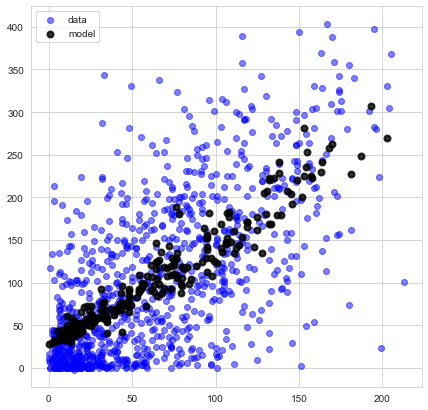

In [294]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# split 20% testing, 80% training data split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print(mean_absolute_error(y_pred, y_test))
fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(111)
ax.scatter(X_train[:,0], y_train,  color='blue', alpha=0.5, label = 'data')
ax.scatter(X_test[:,0], y_pred, color='black', alpha=0.8,linewidth=2, label = 'model')
ax.legend(loc="best");



The above graph is a visualization of the linear regression model with a mean absolute error of 53.781, which means it was off by about 53 points on average, though it is hard to gain much useful information from just the scatter plot, which could have been represented with a line, but the points distribution is very similar.

In [295]:
pd.set_option('display.max_rows', None)

wr_df_pred = df.loc[
    (df['pos'] == 'WR') & (df['offensive_snapcount'] > 50) & (df['season'] == 2021), 
    ['player', 'receiving_tar', 'offensive_snapcount', 'ppr_fantasy_points']
]
wr_df_pred['predicted_ppr_fantasy_points_2022'] = linreg.predict(wr_df_pred[['receiving_tar', 'offensive_snapcount', 'ppr_fantasy_points']].values)
wr_df_pred = wr_df_pred.rename(columns = {'ppr_fantasy_points':'actual_ppr_fantasy_points_2021'})
wr_df_pred.sort_values(by='predicted_ppr_fantasy_points_2022', ascending=False).head(100)


,player,receiving_tar,offensive_snapcount,actual_ppr_fantasy_points_2021,predicted_ppr_fantasy_points_2022
8318,Cooper Kupp,223,1119,522.90,404.371230
12935,Deebo Samuel,134,854,395.10,309.913928
13368,Ja'Marr Chase,162,1078,375.60,293.474140
7763,Tyreek Hill,187,929,365.80,291.217863
6921,Davante Adams,169,886,344.30,275.063288
13153,Justin Jefferson,167,961,337.75,268.669542
6822,Mike Evans,139,931,315.10,250.654255
7528,Stefon Diggs,174,980,298.20,240.097567
12944,Diontae Johnson,179,998,286.80,231.843745
12907,Hunter Renfrow,139,628,272.90,225.978416


Finally, for linear regression the model is used to predict values for 2022. For the sake of clarity it is limited to Wide Receivers, sorted by predicted values.

**Clustering with KMeans**

The scikit-learn algorithm KMeans is useful for assigning points to a single group, and making it appear as such, seeking to minimize the euclidean distance between points. It's easy to use and very popular which is why I'm using it. While it has drawbacks like needing to provide a K value, and trouble dealing with irregularly shaped clusters, I think it is sufficient for my scenario. 

I will use a player rankings set for PPR leagues, and use KMeans to assign each player a tier rank.

I will also be using scikit-lean silhouette_score, that returns a value for the average score of each data point, the highest score indicating a K value with the tightest clusters.

,Rank,Player,Team,Pos,ESPN,Fantrax,Sleeper,AVG,Best,Worst
0,1,Jonathan Taylor,IND,RB,1.0,1.0,1.0,1.0,1,1
1,2,Christian McCaffrey,CAR,RB,2.0,4.0,2.0,3.0,2,4
2,3,Austin Ekeler,LAC,RB,4.0,2.0,4.0,3.0,2,4
3,4,Cooper Kupp,LAR,WR,3.0,3.0,5.0,4.2,3,5
4,5,Derrick Henry,TEN,RB,5.0,6.0,3.0,4.8,3,6


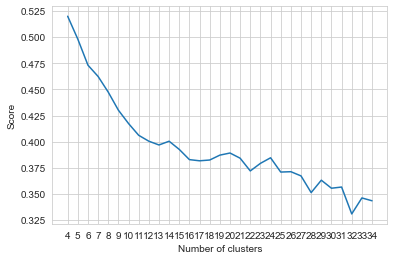

In [296]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns; sns.set_style('whitegrid');
import pandas as pd

df = pd.read_csv('PlayerRankingPPR.csv').dropna()

#434 players
players = 434
df = df[:players]
avgs = []


#test K values
for n_clusters in range(4, 35):    

    model = KMeans(n_clusters=n_clusters)
    model.fit(X) 
    labels = model.predict(X) 
    silhouette_avg = silhouette_score(X, labels) 
    avgs.append(silhouette_avg) 

plt.plot(np.arange(start, stop, 1), avgs);
plt.xlabel('Number of clusters');
plt.ylabel('Score');
plt.xticks(np.arange(start, stop, 1));
df.head()

The range in silohouette score between K values is very small, so multiple values could work fine but going forward I will choose 9.

In [297]:
pd.set_option('display.max_rows', None)
X = df[['AVG']].values
model = KMeans(n_clusters=7)
model.fit(X)
labels = model.predict(X)
#fix the labels so that 1 = top tier ect.
ul = []
tiers = []
for i in labels:
    if i not in ul:
        ul.append(i)
    tiers.append(len(set(ul)))
df['Tier'] = tiers
df.set_index('Tier').head()

,Rank,Player,Team,Pos,ESPN,Fantrax,Sleeper,AVG,Best,Worst
Tier,,,,,,,,,,
1,1,Jonathan Taylor,IND,RB,1.0,1.0,1.0,1.0,1,1
1,2,Christian McCaffrey,CAR,RB,2.0,4.0,2.0,3.0,2,4
1,3,Austin Ekeler,LAC,RB,4.0,2.0,4.0,3.0,2,4
1,4,Cooper Kupp,LAR,WR,3.0,3.0,5.0,4.2,3,5
1,5,Derrick Henry,TEN,RB,5.0,6.0,3.0,4.8,3,6


In [298]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set_style('whitegrid')
k = 9

def graph(df, pos=None, figsize=(20, 20)): 

    if pos:
        df = df.loc[df['Pos'].str.contains(pos)] 

    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'magenta', 'grey', 'maroon']   
    #code colors to tier
    colors = dict(zip(range(1, k+1), colors[:k]))
    plt.figure(figsize=figsize)

    plt.scatter(x = df['AVG'], y = df['Rank'], c ='black', alpha = 1, s = 7)
    yticks = [] 
    
    for _, row in df.iterrows():       

        xmin = row['Best'] 
        xmax = row['Worst']
        ymin, ymax = row['Rank'], row['Rank'] 
        player = row['Player'] 
        tier = row['Tier']
        plt.plot((xmin, xmax), (ymin, ymax), c=colors.get(tier, 'black'), alpha=0.8)
        yticks.append(player)
        
    patches = []
    
    for tier, color in colors.items():
        patch = mpatches.Patch(color=color, label=f'Tier {tier}') 
        patches.append(patch)
        
    plt.legend(handles=patches, borderpad=1, fontsize=12) 
    plt.xlabel('Average Rank', fontsize=12)
    plt.ylabel('Consensus Rank', fontsize=12)
    plt.yticks(df['Rank'], yticks, fontsize=12)
    plt.title('Tiers For 2022 Draft', fontsize=12)
    plt.gca().invert_yaxis()
    plt.show()

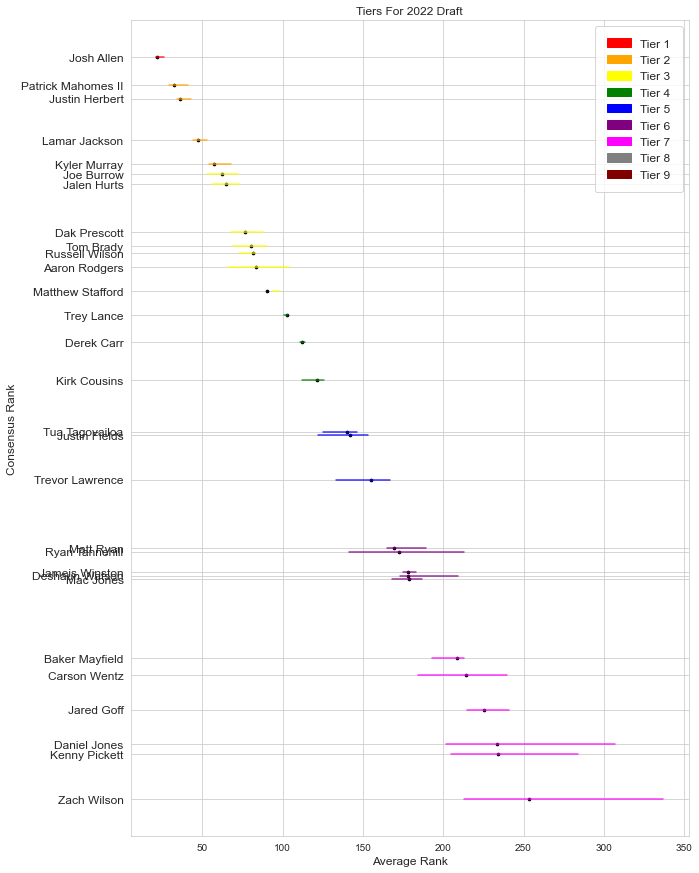

In [299]:
graph(df, 'QB', figsize=(10, 15))

Graph of all draftable quarterbacks.

**Conclusions of KMean**

By assigning each player a tier, it is easier to place value on when to draft players.  The graph visualizes the variation in overall ranks that are assigned by to each player while showing the teir ranks that have been created by selecting a K value for KMeans.  An example of what you could use this for is how there is only one QB that has been grouped into tier one, which would be very valuable information when drafting.  

**Overall Conclusions**

While my analysis is fairly basic, through my project I have seen how machine learning principles can be applied to Fantasy Football, and that extends to any hobby that uses that much data. I find, analyzing extremely large data sets that are hard to interpret much less interesting that the sets I have used in my project, where I could personally verify the importance and meaing of each piece of data that is inlcuded, so I feel more confident interpreting results and drawing conclusions.     